# Black-Box optimization

In [1]:
import os

import requests
from urllib.parse import urlparse, urljoin

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

data = np.load('../../../share/SUSY-small.npy')

X_all, y_all = data[:, 1:], data[:, 0]

X_train, X_rest, y_train, y_rest = train_test_split(X_all, y_all, test_size=0.5)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5)

print('Train     :', X_train.shape, y_train.shape)
print('Validation:', X_val.shape, y_val.shape)
print('Test      :', X_test.shape, y_test.shape)

Train     : (50000, 18) (50000,)
Validation: (25000, 18) (25000,)
Test      : (25000, 18) (25000,)


In [3]:
def plot(f, history=None, trajectory=False):
    xs = np.linspace(-0.5, 2.5, num=250)
    X, Y = np.meshgrid(xs, xs)

    Z = np.stack([X.reshape(-1), Y.reshape(-1)], axis=1)
    F = f(Z[:, 0], Z[:, 1]).reshape(xs.shape[0], xs.shape[0])
    
    plt.figure(figsize=(6, 6))
    plt.ylim([-0.5, 2.5])
    plt.xlim([-0.5, 2.5])

    plt.contour(
        xs, xs, F,
        levels=np.linspace(0, 4, num=20),
        colors=[plt.cm.tab10(0)]
    )
    plt.scatter([1], [1], marker='*', s=500, color=plt.cm.tab10(3), zorder=5)
    
    if history is not None:
        plt.scatter(history[:, 0], history[:, 1], color=plt.cm.tab10(1), s=100)
        if trajectory:
            plt.plot(history[:, 0], history[:, 1], color=plt.cm.tab10(1), lw=3)
    
    plt.tight_layout()
    plt.show()

## The first objective function

The first objective function is one of the most popular benchmark functions --- the Resenbrock function.
We slightly modify it by applying $\chi \to \log (1 + \chi)$.

In [4]:
def log_resenbrock(x1, x2):
    return np.log1p(
        (1 - x1) ** 2 + 1 * (x2 - x1 ** 2) ** 2
    )

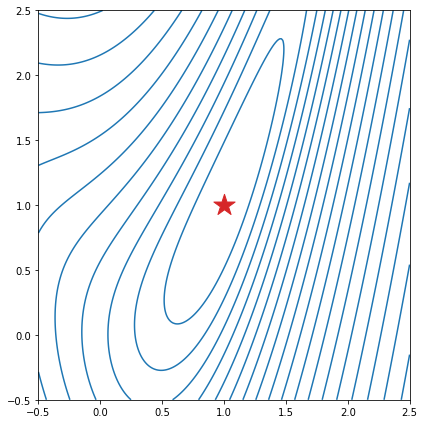

In [5]:
plot(log_resenbrock)

## The second objective function

One of use-cases for black-box optimization is hyper-parameter tuning.
Here, we measure quality of XGBoost as a function of two continous parameters --- learning rate and regularization coefficient.
The dataset is a small version of the [SUSY](https://archive.ics.uci.edu/ml/datasets/SUSY) dataset (loaded above).

In [6]:
### NOTE, due to problems with XGBoost on cocalc the objective function was changed
### to the one based on sklearn's GradientBoostingClassifier.
### Unfortunately, there is not equivalent of reg_lambda in GradientBoostingClassifier.
### New objective function uses ccp_alpha instead, which has somewhat similar meaning.

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

def eval_xgb_quality(log_learning_rate, log_reg_lambda):
    learning_rate = np.exp(log_learning_rate)
    ### NOTE: added -3 to the log_reg_lambda
    reg_lambda = np.exp(log_reg_lambda - 3)

    clf = GradientBoostingClassifier(
        learning_rate=learning_rate,
        ccp_alpha=reg_lambda,

        n_estimators=100,
        max_depth=3,

        subsample=1e-1,
        random_state=111
    )
    
    clf.fit(X_train, y_train)
    predictions = clf.predict_proba(X_val)
    
    return 1 - accuracy_score(y_val, predictions[:, 1] > 0.5)

In [7]:
%%time

### baseline quality is for comparison
baseline_XGB = eval_xgb_quality(0, 0)
print('XGBoost baseline: %.3lf' % (baseline_XGB,) )
print('%.3lf' % (eval_xgb_quality(-1, -2)))

XGBoost baseline: 0.278


0.241
CPU times: user 7.23 s, sys: 0 ns, total: 7.23 s
Wall time: 7.23 s


## Task 1: Random Search

- implement sampling for Random Search.

In [8]:
def random_search(f, bounds, n_evaluations=20, progress=lambda x: x, seed=111222):
    bounds = np.array(bounds)
    
    history_x = []
    history_f = []
    
    rng = np.random.RandomState(seed=seed)
    ### rng has the same methods as np.random,
    ### e.g., rng.uniform - np.random.uniform
    
    for _ in progress(range(n_evaluations)):
        u = rng.uniform(0, 1, size=bounds.shape[0])
        x = u * (bounds[:, 1] - bounds[:, 0]) + bounds[:, 0]

        value = f(*x)
        
        history_x.append(x)
        history_f.append(value)
    
    best = np.argmin(history_f)
    history_x = np.array(history_x)
    
    return history_x[best], history_f[best], history_x

In [9]:
x, _, history = random_search(
    log_resenbrock, 
    bounds=[(-0.5, 2.5), (-0.5, 2.5)],
    progress=tqdm,
    n_evaluations=1000
)

assert log_resenbrock(x[0], x[1]) < 1e-2

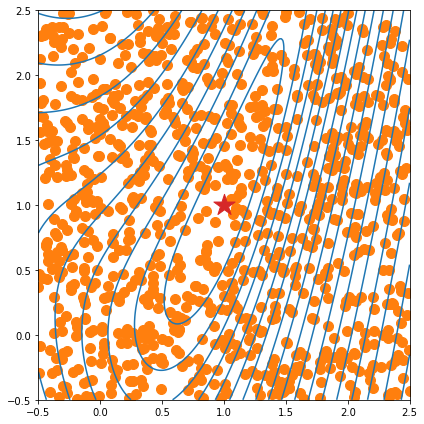

In [10]:
plot(log_resenbrock, history, trajectory=False)

In [11]:
x, error, history = random_search(eval_xgb_quality, bounds=[(-3, 3), (-3, 3)], progress=tqdm)

test_quality = eval_xgb_quality(*x)

assert test_quality < baseline_XGB, 'Looks like the optimization algorithm did not improved over baseline'

## Task 2: numerical gradient estimation

- implement numerical gradient estimation.

In [12]:
def numerical_gradient(f, x0, learning_rate=1e-1, h=1e-2, n_evaluations=20, progress=lambda x: x):
    n_iters = (n_evaluations - 1) // (1 + x0.shape[0])
    current_x = x0
    
    history_x = [current_x]
    
    for _ in progress(range(n_iters)):
        f_current = f(*current_x)
        
        df = np.zeros(shape=current_x.shape)
        
        for j in range(current_x.shape[0]):
            x = np.copy(current_x)
            x[j] = x[j] - h
            
            df[j] = f_current - f(*x)
        
        grad = df / h
        
        current_x = current_x - learning_rate * grad
        
        history_x.append(np.copy(current_x))
    
    return current_x, f(*current_x), np.array(history_x)

In [13]:
x, _, history = numerical_gradient(
    log_resenbrock,
    x0=np.array([0.5, 0.5]),
    progress=tqdm,
    
    n_evaluations=2500
)

assert np.all(np.abs(x - 1) < 1e-1)

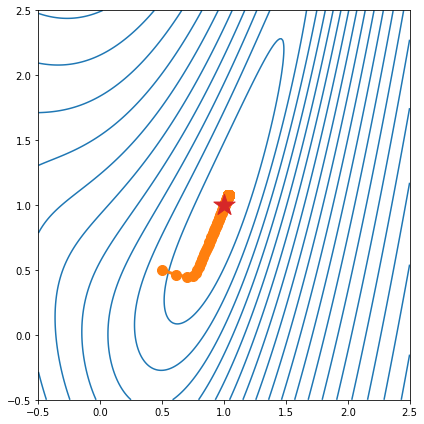

In [14]:
plot(log_resenbrock, history, trajectory=True)

In [20]:
class Function(object):
    def __init__(self, f, max_evals=20):
        self.max_evals = max_evals
        self.n_evals = 0
        self.f = f
    
    def __call__(self, *args, **kwargs):
        if self.n_evals >= self.max_evals:
            raise Exception('Reached maximal number of evaliations')
        else:
            self.n_evals += 1

        return self.f(*args, **kwargs)
    
x, _, history = numerical_gradient(
    Function(eval_xgb_quality, 20),
    x0=np.zeros(2),

    learning_rate=1e+1, h=1e-1,
    
    n_evaluations=20,
    progress=tqdm
)

test_quality = eval_xgb_quality(*x)

assert test_quality < baseline_XGB, 'Looks like the optimization algorithm did not improved over baseline'

AssertionError: Looks like the optimization algorithm did not improved over baseline

## Task 3: Simulated Annealing

Implement simulated annealing:
- use normally distribited noise with `std=learning_rate` for generating suggestions:
  $$\begin{eqnarray}
  x'_{t + 1} &=& x_t + \varepsilon;\\
  \varepsilon &\sim& \mathcal{N}(0, \sigma^2 = \mathrm{lr}^2)
  \end{eqnarray}$$

- accept new point if:
  $$x_{t + 1} = \begin{cases}
      x_{t + 1}, &\text{ if } f(x'_{t + 1}) < f(x_{t});\\
      x_{t + 1}, &\text{ with } P = \exp\Big( \frac{\big(f(x_{t}) - f(x'_{t + 1})\big)}{T} \Big);\\
      x_t  &\text{ otherwise} 
  \end{cases}$$

- try different temperature schedules and learning_rates.

In [16]:
def simulated_annealing(
    f, x0,
    learning_rate=1e-1, T0=1e-1, T_final=1e-3,
    n_evaluations=20, seed=100, progress=lambda x: x
):

    current_x = x0
    current_f = f(*x0)
    
    history_x = [current_x]
    history_f = [current_f]
    
    rng = np.random.RandomState(seed=seed)
    
    ### for numerical stability
    ### instead of
    ### exp((f1 - f0) / T) > unifrom(0, 1)
    ### one can use 
    ### (f1 - f0) > np.log(unifrom(0, 1) + eps) * T
    
    for i in progress(range(n_evaluations - 1)):
        T = T0 - (T0 - T_final) * i / (n_evaluations - 1)

        suggestion = current_x + learning_rate * rng.normal(size=x0.shape)
        f_suggestion = f(*suggestion)
        
        prob = (current_f - f_suggestion)
        
        if prob > np.log(rng.uniform(0, 1) + 1e-6) * T:
            current_f = f_suggestion
            current_x = suggestion
        else:
            pass
        
        history_x.append(current_x)
        history_f.append(current_f)
    
    best = np.argmin(history_f)
    
    return history_x[best], history_f[best], np.array(history_x)

In [17]:
x, _, history = simulated_annealing(
    log_resenbrock,
    x0=np.array([0.5, 0.5]),
    
    learning_rate=5e-2, T0=1e-1, T_final=1e-3,
    
    n_evaluations=250,
    seed=1111,
    progress=tqdm,
)

assert np.all(np.abs(x - 1) < 2e-1)

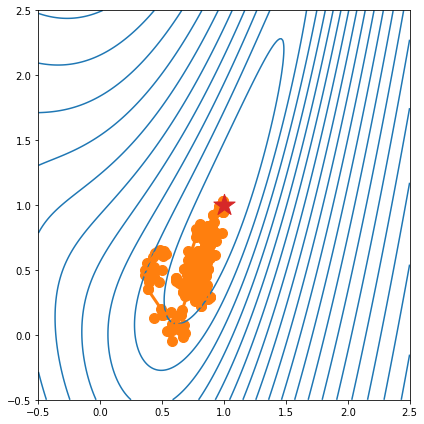

In [18]:
plot(log_resenbrock, history, trajectory=True)

In [19]:
class Function(object):
    def __init__(self, f, max_evals=20):
        self.max_evals = max_evals
        self.n_evals = 0
        self.f = f
    
    def __call__(self, *args, **kwargs):
        if self.n_evals >= self.max_evals:
            raise Exception('Reached maximal number of evaliations')
        else:
            self.n_evals += 1

        return self.f(*args, **kwargs)
    
x, _, history = simulated_annealing(
    Function(eval_xgb_quality, 20),
    x0=np.zeros(2),
    
    learning_rate=1e-1, T0=1e-1, T_final=1e-3,
    
    n_evaluations=20,
    seed=1111,
    progress=tqdm
)

test_quality = eval_xgb_quality(*x)

assert test_quality < baseline_XGB, 'Looks like the optimization algorithm did not improved over baseline'